In [1]:
import pandas as pd
import numpy as np

In [2]:
stock = pd.read_csv('HPG Historical Data.csv')
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values(by='Date')
stock = stock.set_index('Date')
stock['Price'] = stock['Price'].str.replace(',', '').astype(float)
stock['Open'] = stock['Open'].str.replace(',', '').astype(float)
stock['High'] = stock['High'].str.replace(',', '').astype(float)
stock['Low'] = stock['Low'].str.replace(',', '').astype(float)
stock['Vol.'] = stock['Vol.'].str.replace('M', '').astype(float)
stock['Change %'] = stock['Change %'].str.replace('%', '').astype(float)


In [3]:
r_t = np.log(stock['Price'] / stock['Price'].shift(1)).dropna()
r_t = r_t.values



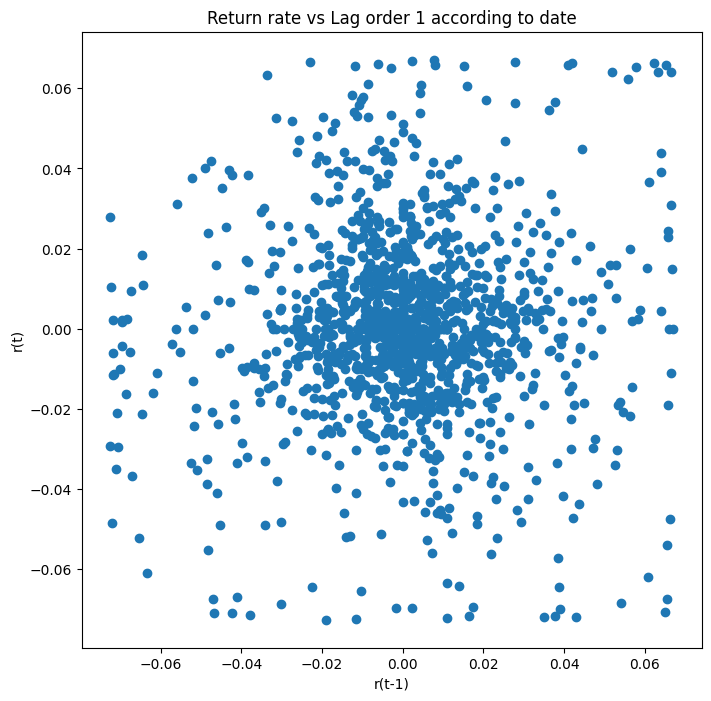

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -34.838689
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


P<0.05 reject the H0 hypothesis 

<Figure size 800x600 with 0 Axes>

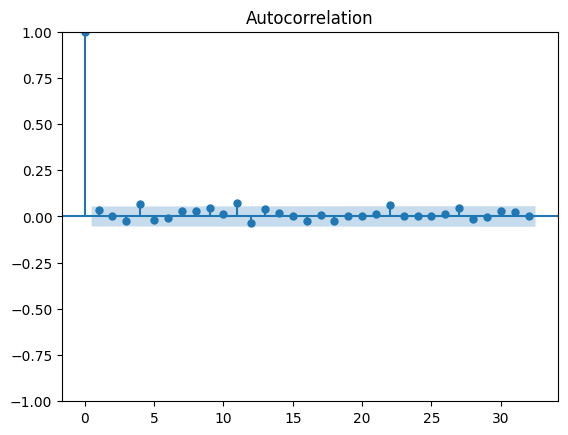

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(8, 6))
ax1 = plot_acf(r_t)


<Figure size 800x600 with 0 Axes>

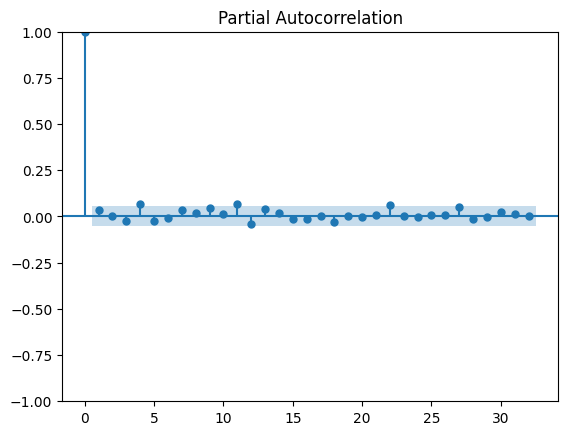

In [17]:
plt.figure(figsize=(8, 6))
ax2 = plot_pacf(r_t)

In [69]:
# find the date at the index 1057
# stock.index[1035]

print(len(r_t))
print(len(stock.index))
# Check if r_t have null value


1307
1308


In [12]:
r_t[1306]

0.0

In [13]:
from statsmodels.tsa.arima.model import ARIMA
orders = [(2, 0, 2), (2, 0, 0), (5, 0, 0), (0, 0, 5)]
#compare different orders of ARIMA model aiming to find the best one
# The train data from January 2 2018 to February 28 2022 
# The test data from March 1 2022 to March 31 2023
train = r_t[:1035]
test = r_t[1035:]
best_aic = np.inf
best_order = None
for order in orders:
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_order = order
print('Best order:', best_order)


    

Best order: (0, 0, 5)


In [18]:
len(train)

1035

In [21]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()
r_t_pred = model_fit.predict(start=1035, end=1306)












In [22]:
len(r_t_pred)

272

In [24]:
stock.index[1035]

Timestamp('2022-03-01 00:00:00')

/tmp/ipykernel_4215/2150285503.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock['Price'].iloc[1035 + i] = stock['Price'].iloc[1034 + i] * (1 + r_t_pred[i])
/tmp/ipykernel_4215/2150285503.py:4: FutureWarning: ChainedAssignmentError: 

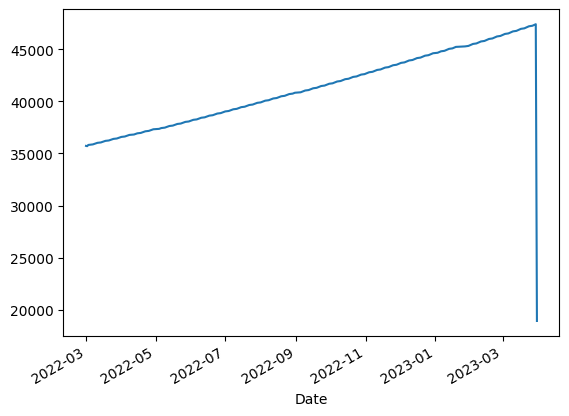

In [31]:
# from r_t_pred convert to stock['Price'] by using the formula

for i in range(0, len(r_t_pred)):
    stock['Price'].iloc[1035 + i] = stock['Price'].iloc[1034 + i] * (1 + r_t_pred[i])

stock['Price'].iloc[1035:].plot()
plt.show()





In [32]:
#Dickey-Fuller test. The null hypothesis of the test is that the time series is not stationary.
from statsmodels.tsa.stattools import adfuller
result = adfuller(stock['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# The p-value is greater than 0.05, so we cannot reject the null hypothesis that the time series is not stationary.
# We need to difference the time series to make it stationary.
stock['Price Difference'] = stock['Price'] - stock['Price'].shift(1)
result = adfuller(stock['Price Difference'].dropna())
print('ADF Statistic: %f' % result[0])  
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# The p-value is less than 0.05, so we can reject the null hypothesis that the time series is not stationary.



ADF Statistic: -1.349881
p-value: 0.606054
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF Statistic: -16.282967
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


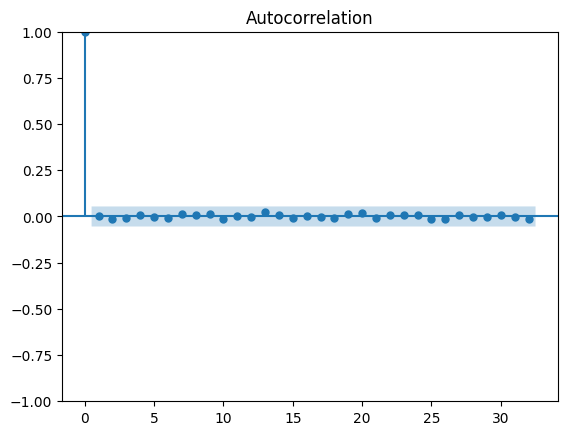

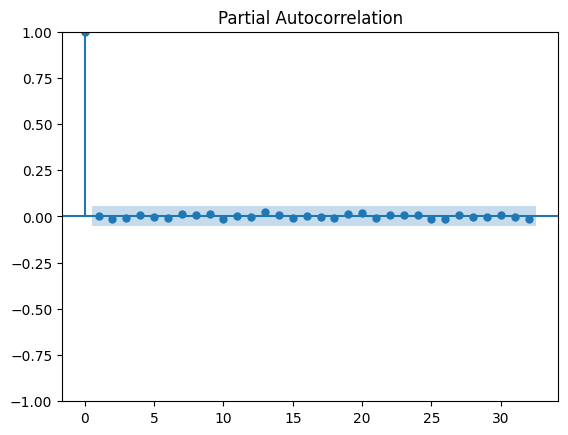

In [33]:
#using Plot the ACF and PACF charts and find the optimal parameters for the ARIMA model.
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(stock['Price Difference'].dropna())
plot_pacf(stock['Price Difference'].dropna())
plt.show()

# The ACF chart shows a significant spike at lag 1, so we should use p=1.
# The PACF chart shows a significant spike at lag 1, so we should use q=1.
# The d=1 because we differenced the time series once to make it stationary.




/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

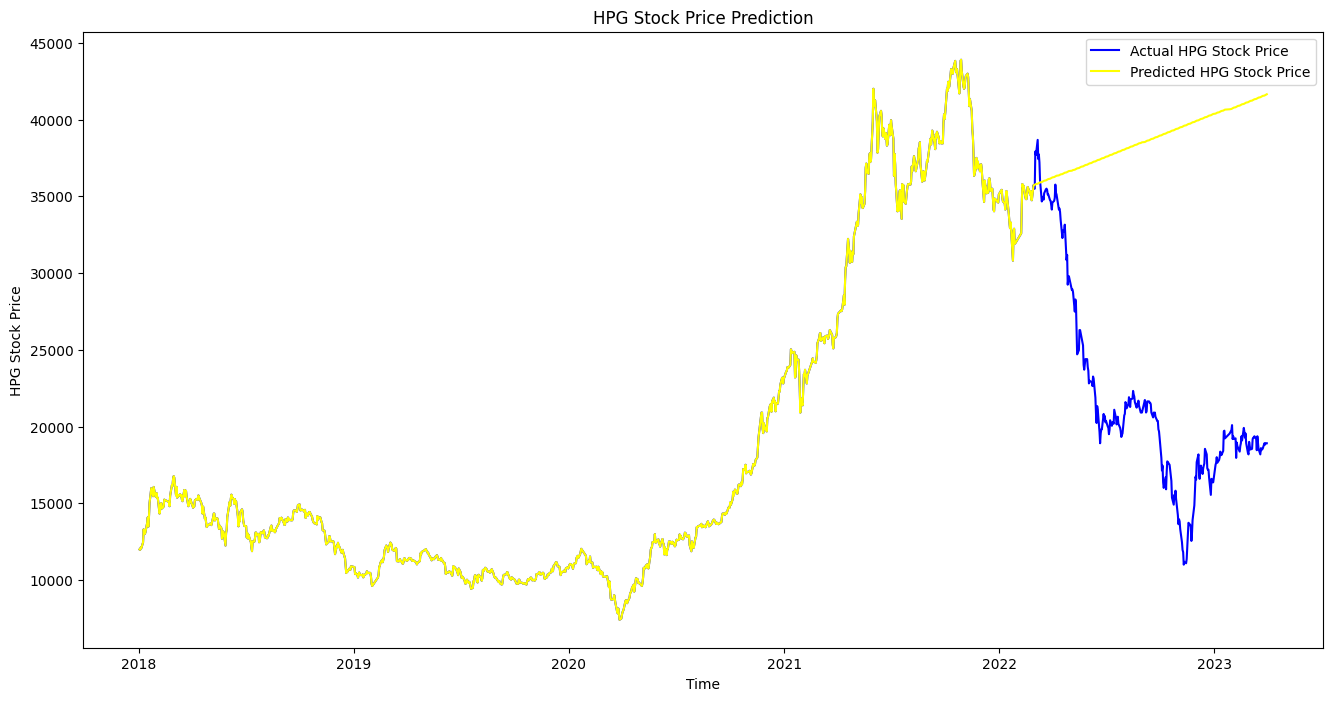

In [7]:
# Fit the ARIMA model to the stationary time series.
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(stock['Price difference '], order=(1,1,1))



In [24]:
print(model_fit.params)

ar.L1         -0.884893
ma.L1          0.915995
sigma2    209086.732132
dtype: float64
